In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score

In [3]:
# function that iterates through a set of signals to compute the markov feature vectors

def markov_feature_vectors(signals, k=6):
    
    num_signals = signals.shape[0]
    
    data = np.zeros(shape=(num_signals, k * k * 3))
    
    for idx in range(num_signals):
        data[idx] = compute_markov_matrix_feature_vector(signals[idx], k)
        
    return data

In [4]:
# computin the markov matrix feature vector foar a given signal and k num of intervals for discretization

def compute_markov_matrix_feature_vector(signal, k=6):
    
    min, max = -4.49, 13.47 # min si max luate din testing
    bins = np.linspace(start=min, stop=max, num=k+1, endpoint=True)
    signal = np.asarray(signal)
    feature_vector = []
    
    for axis in range(3):
        axis_signal = signal[:, axis]
        discrete_axis_signal = np.digitize(x=axis_signal, bins=bins) - 1
        matrix = np.zeros(shape=(k,k))
        
        for idx in range(len(discrete_axis_signal)-1):
            matrix[discrete_axis_signal[idx]][discrete_axis_signal[idx+1]] += 1
        
        row_sums = matrix.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        normalized_matrix = matrix / row_sums
        
        feature_vector.extend(np.reshape(normalized_matrix, newshape=k*k))
        
    return feature_vector

In [5]:
#kNN class

class KnnClassifier:
    
    def __init__(self, train_signals, train_labels):
        self.train_signals = np.asarray(train_signals)
        self.train_labels = np.asarray(train_labels)
        
    def classify_signal(self, test_signal, num_neighbors=3):
        
        distances = np.sum((np.abs(self.train_signals - test_signal)), axis=1)
           
        sorted_indexes = np.argsort(distances)[:num_neighbors]
        nearest_labels = self.train_labels[sorted_indexes]
        
        histogram = np.bincount(nearest_labels)

        return np.argmax(histogram)
    
    def classify_signals(self, test_signals, num_neighbors=3):

        num_predictions = test_signals.shape[0] 
        predictions = np.zeros(num_predictions)
    
        for i in range(num_predictions):
            predictions[i] = self.classify_signal(test_signals[i], num_neighbors)
    
        return predictions

def accuracy(y_true, y_preds):

        return (y_true == y_preds).mean()
        

In [9]:
# loading the data and transforming it into feature vectors

df_train = pd.read_csv('csvs/train.csv')
train_paths = df_train['filename'].tolist()
train_labels = df_train['label'].tolist()

df_test = pd.read_csv('csvs/test.csv')
test_paths = df_test['filename'].tolist()
test_labels = df_test['label'].tolist()

 # here we can switch data_long with data_short
train_paths = ['data_long/train/' + path for path in train_paths]
test_paths = ['data_long/test/' + path for path in test_paths]

train_data = []
for file_path in train_paths:
    data = np.loadtxt(file_path, delimiter=",").astype(np.float32)
    train_data.append(data)
train_data = np.asarray(train_data)
    
    
test_data = []
for file_path in test_paths:
    data = np.loadtxt(file_path, delimiter=",").astype(np.float32)
    test_data.append(data)
test_data = np.asarray(test_data)

train_data = markov_feature_vectors(train_data, k=6)
test_data = markov_feature_vectors(test_data, k = 6)
    

### kNN

In [10]:
# kNN testing

num_neighbours = list(range(1, 50, 2))

train_acc_list = []
test_acc_list = []

for nn in num_neighbours:

    knn_classifier = KnnClassifier(train_data, train_labels)
    
    predicted_train_labels = knn_classifier.classify_signals(train_data, num_neighbors=nn)
    predicted_test_labels = knn_classifier.classify_signals(test_data, num_neighbors=nn)
    
    train_acc = accuracy(train_labels, predicted_train_labels)
    test_acc = accuracy(test_labels, predicted_test_labels)
    
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    

In [8]:
short_train_acc_list = np.copy(train_acc_list)
short_test_acc_list = np.copy(test_acc_list)

In [11]:
long_train_acc_list = np.copy(train_acc_list)
long_test_acc_list = np.copy(test_acc_list)

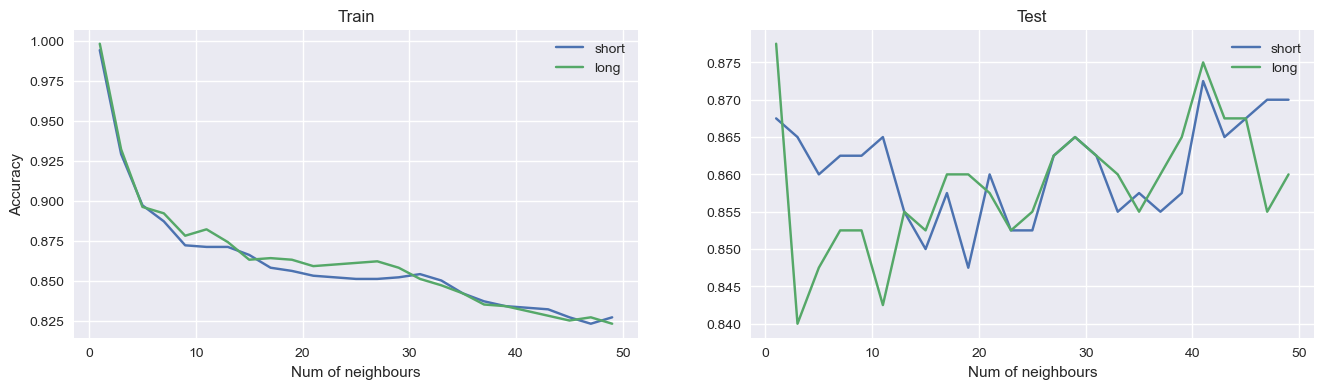

In [13]:
# graphs for kNN results

plt.style.use('seaborn-v0_8')
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharex=True)

ax1.plot(num_neighbours, short_train_acc_list, label='short')
ax1.plot(num_neighbours, long_train_acc_list, label='long')
ax1.set_title('Train')
ax1.set_xlabel('Num of neighbours')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(num_neighbours, short_test_acc_list, label='short')
ax2.plot(num_neighbours, long_test_acc_list, label='long')
ax2.set_title('Test')
ax2.set_xlabel('Num of neighbours')
ax2.legend()


plt.savefig('knn-results.png')
plt.show()

### SVM

In [14]:
# SVM

def intersection_kernel(v1, v2):
    
    return np.sum(np.minimum(v1, v2))

def kernel_matrices(train_data, test_data, kernel):
    
    num_train_samples = train_data.shape[0]
    num_test_samples = test_data.shape[0]
    
    K_train = np.zeros(shape=(num_train_samples, num_train_samples))
    K_test = np.zeros(shape=(num_test_samples, num_train_samples))
    
    for i in range(num_train_samples):
        for j in range(num_train_samples):
            K_train[i,j] = kernel(train_data[i], train_data[j])
            
    for i in range(num_test_samples):
        for j in range(num_train_samples):
            K_test[i,j] = kernel(test_data[i], train_data[j])
    
    return K_train, K_test



In [15]:
K_train, K_test = kernel_matrices(train_data, test_data, kernel=intersection_kernel)

In [36]:
power = list(range(-3,4,1))

svm_train_acc_list = []
svm_test_acc_list = []

for p in power:

    # svm_classifier = svm.SVC(C=10 ** p, kernel='precomputed')  # intersection kernel
    # svm_classifier.fit(K_train, train_labels) # intersection kernel
    
    svm_classifier = svm.SVC(C=10 ** p, kernel='rbf') # other kernels
    svm_classifier.fit(train_data, train_labels) # other kernels
    

    # predicted_train_labels = svm_classifier.predict(K_train) # intersection kernel
    predicted_train_labels = svm_classifier.predict(train_data) # other kernels
    svm_train_acc = accuracy_score(y_true=train_labels, y_pred=predicted_train_labels)
    svm_train_acc_list.append(svm_train_acc)
    
    # predicted_test_labels = svm_classifier.predict(K_test) # intersection kernel
    predicted_test_labels = svm_classifier.predict(test_data) # other kernels
    svm_test_acc = accuracy_score(y_true=test_labels, y_pred=predicted_test_labels)
    svm_test_acc_list.append(svm_test_acc)
    

In [31]:
svm_train_acc_intersection = np.copy(svm_train_acc_list)
svm_test_acc_intersection = np.copy(svm_test_acc_list)

In [33]:
svm_train_acc_linear = np.copy(svm_train_acc_list)
svm_test_acc_linear = np.copy(svm_test_acc_list)

In [35]:
svm_train_acc_poly = np.copy(svm_train_acc_list)
svm_test_acc_poly = np.copy(svm_test_acc_list)

In [37]:
svm_train_acc_rbf = np.copy(svm_train_acc_list)
svm_test_acc_rbf = np.copy(svm_test_acc_list)

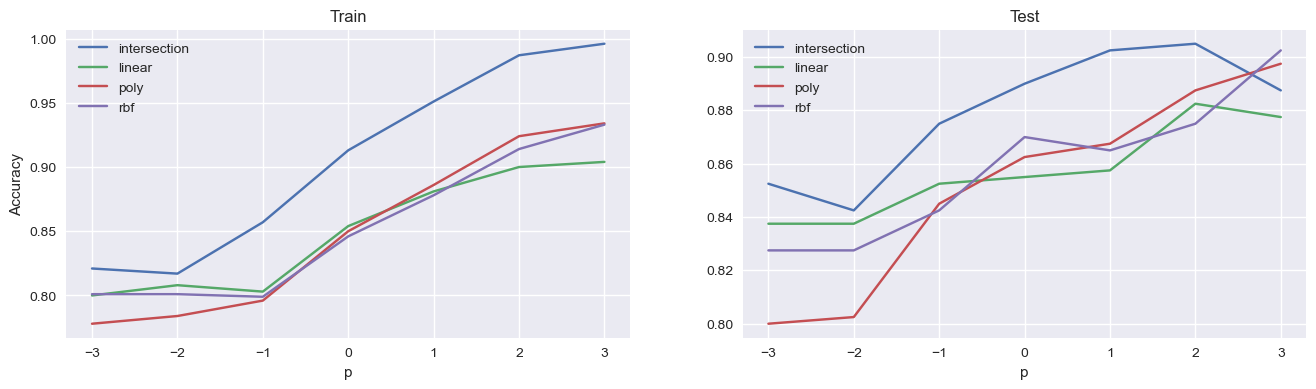

In [42]:
plt.style.use('seaborn-v0_8')
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharex=True)

ax1.plot(power, svm_train_acc_intersection, label='intersection')
ax1.plot(power, svm_train_acc_linear, label='linear')
ax1.plot(power, svm_train_acc_poly, label='poly')
ax1.plot(power, svm_train_acc_rbf, label='rbf')
ax1.set_title('Train')
ax1.set_xlabel('p')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(power, svm_test_acc_intersection, label='intersection')
ax2.plot(power, svm_test_acc_linear, label='linear')
ax2.plot(power, svm_test_acc_poly, label='poly')
ax2.plot(power, svm_test_acc_rbf, label='rbf')
ax2.set_title('Test')
ax2.set_xlabel('p')
ax2.legend()

plt.savefig('svm-results.png')
plt.show()